In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [14]:
# Load data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [15]:
# Merging the customer data and transaction data on 'CustomerID'
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID')

In [16]:
# Feature Engineering: Aggregate transaction data for each customer
customer_features = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    total_quantity=('Quantity', 'sum')
).reset_index()

In [17]:
# Merging with customer profile data (e.g., region, signup date)
customer_profile = customers_df[['CustomerID', 'Region']]
customer_features = pd.merge(customer_features, customer_profile, on='CustomerID')

In [18]:
# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['total_spent', 'num_transactions', 'avg_transaction_value', 'total_quantity']])

In [19]:
# Applying KMeans Clustering (for k = 2 to 10)
results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    
    # Compute Davies-Bouldin index
    db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
    
    # Append the results for each k
    results.append({
        'k': k,
        'db_index': db_index,
        'silhouette_score': silhouette_avg
    })

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

In [20]:
# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results)

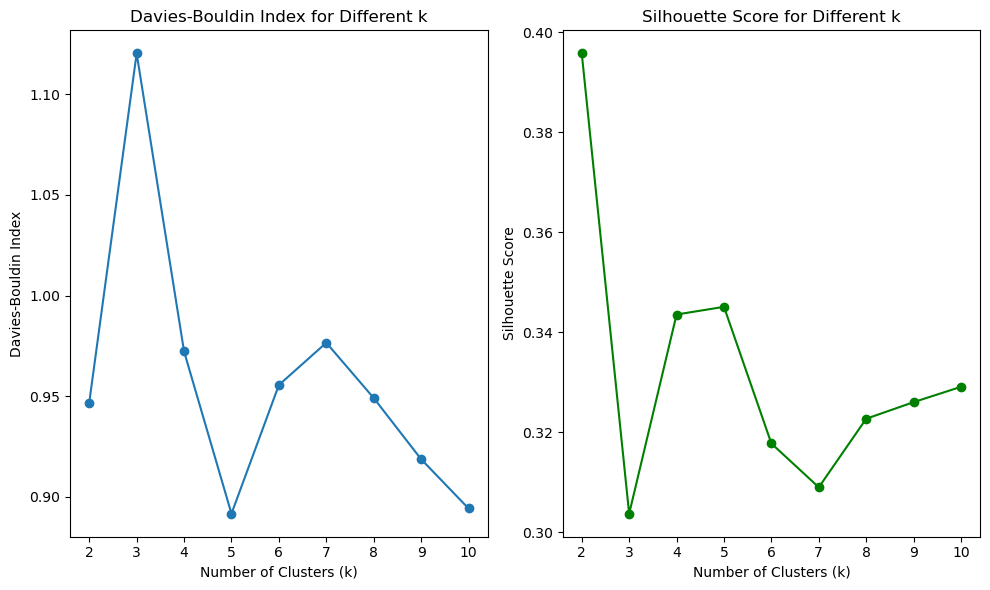

In [21]:

# Plot DB Index and Silhouette Scores
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(results_df['k'], results_df['db_index'], marker='o')
plt.title('Davies-Bouldin Index for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')

plt.subplot(1, 2, 2)
plt.plot(results_df['k'], results_df['silhouette_score'], marker='o', color='g')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



In [22]:
# Selecting the best k based on the DB index or silhouette score
best_k = results_df.loc[results_df['silhouette_score'].idxmax()]['k']
print(f"Best number of clusters based on silhouette score: {best_k}")

Best number of clusters based on silhouette score: 2.0


Best number of clusters based on silhouette score: 2


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


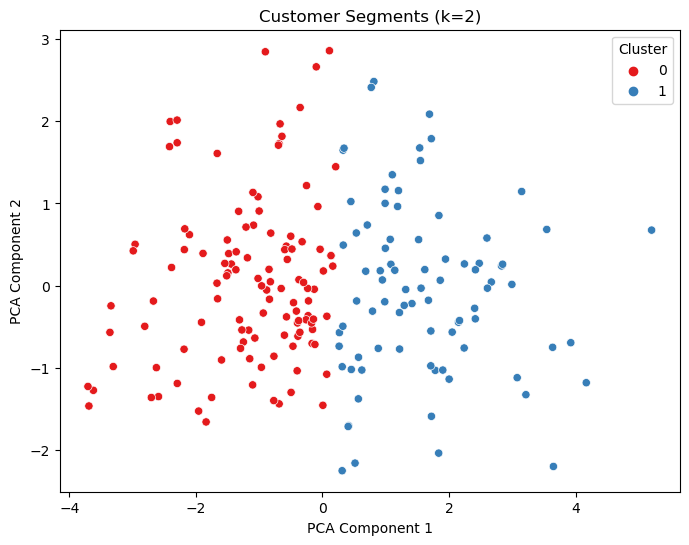

In [24]:
# Ensure best_k is an integer
best_k = int(results_df.loc[results_df['silhouette_score'].idxmax()]['k'])
print(f"Best number of clusters based on silhouette score: {best_k}")

# Apply KMeans with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(scaled_features)

# Add the cluster labels to the customer data
customer_features['Cluster'] = kmeans.labels_

# Visualize the clusters using PCA (2D visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_features['Cluster'], palette='Set1')
plt.title(f'Customer Segments (k={best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

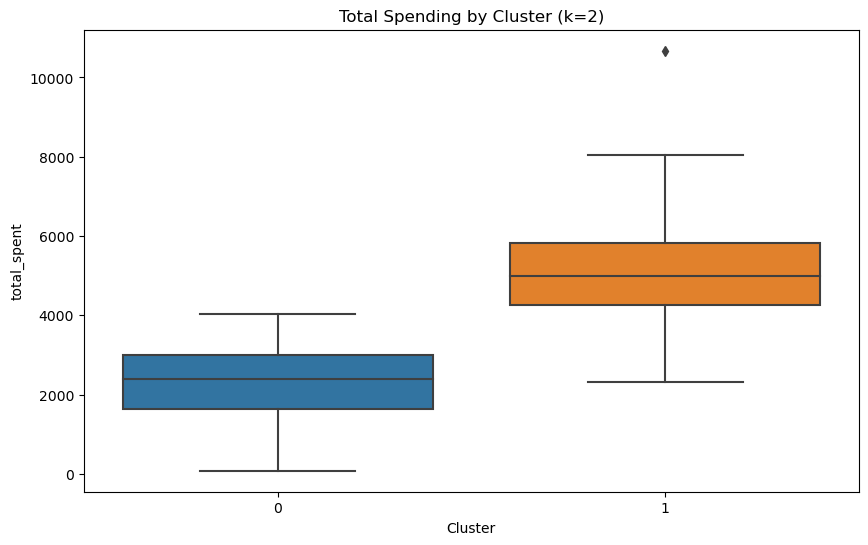

In [25]:
# Optional: Visualize customer clusters in terms of key features
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='total_spent', data=customer_features)
plt.title(f'Total Spending by Cluster (k={best_k})')
plt.show()

In [26]:
# Save the customer features with cluster labels
customer_features.to_csv('Customer_Clusters.csv', index=False)